In [1]:
import torch
import numpy as np
import time
import os
import psutil

np.random.seed(123)

In [2]:
# TODO: Rename variables

from IPython.display import Image, display
from matplotlib import pyplot as plt

def load_data(data_dir, prefix, suffix):
    # Load data in a loop
    dirents = os.listdir(data_dir)
    dirents = [os.path.join(data_dir, d) for d in dirents]
    files = [f for f in dirents if os.path.isfile(f)]
    real_prefix = os.path.join(data_dir, prefix)
    files = [f for f in files if f.startswith(real_prefix) and f.endswith(suffix)]
            
    def get_it(path):
        fname = os.path.basename(path)
        it = fname[len(prefix):-len(suffix)]
        return int(it)
    files.sort(key=get_it)

    code_list = list()
    label_list = list()
    path_list = list()
    device = torch.device('cpu')

    for f in files:
        data = torch.load(f, map_location=device)

        code_list.append(data['rep'])
        label_list.append(data['class'])
        path_list = path_list + data['paths']
        print(f)
        
    return {
        'codes': np.concatenate(code_list, 0),
        'targets': np.concatenate(label_list, 0),
        'paths': path_list
    }


In [3]:

train_prefix = '2048dim_train_reps_'
val_prefix = '2048dim_val_reps_'
suffix = '.pt'

## ImageNet info
# NUM_CLASSES = 1000
# DATA_DIR = '/home/howarwil/data/imagenet_reps'
# DATASET = 'imagenet1k'
# VAL_PER_CLASS = 50

## Places info
NUM_CLASSES = 365
DATA_DIR = '/home/howarwil/data/places365_reps'
DATASET = 'places365'
VAL_PER_CLASS = 100

print("loading data...")

val_data = load_data(DATA_DIR, val_prefix, suffix)
test_paths = val_data['paths']

train_data = load_data(DATA_DIR, train_prefix, suffix)
train_paths = train_data['paths']

loading data...
/home/howarwil/data/places365_reps/2048dim_val_reps_32.pt
/home/howarwil/data/places365_reps/2048dim_val_reps_64.pt
/home/howarwil/data/places365_reps/2048dim_val_reps_96.pt
/home/howarwil/data/places365_reps/2048dim_val_reps_128.pt
/home/howarwil/data/places365_reps/2048dim_val_reps_142.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_32.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_64.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_96.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_128.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_160.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_192.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_224.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_256.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_288.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_320.pt
/home/howarwil/data/places365_reps/2048dim_train_reps_352.pt
/home/howarwil/data/plac

In [4]:
train_codes = train_data['codes']
train_codes /= np.linalg.norm(train_codes, axis=1).reshape(-1, 1)
train_classes = train_data['targets'].reshape(-1, 1)

orig_val_codes = val_data['codes']
orig_val_codes /= np.linalg.norm(orig_val_codes, axis=1).reshape(-1, 1)
orig_val_classes = val_data['targets'].reshape(-1, 1)

print(f"Shape of training data is {train_codes.shape}")
print(f"Shape of training labels is {train_classes.shape}")

print(f"Shape of test data is {orig_val_codes.shape}")
print(f"Shape of test labels is {orig_val_classes.shape}")

Shape of training data is (1803460, 2048)
Shape of training labels is (1803460, 1)
Shape of test data is (36500, 2048)
Shape of test labels is (36500, 1)


length of training paths list is 1803460
	displaying image from /home/howarwil/data/places365/places365_standard/train/booth-indoor/00001789.jpg


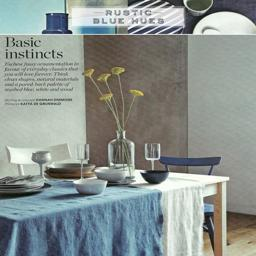

	displaying image from /home/howarwil/data/places365/places365_standard/train/butte/00002156.jpg


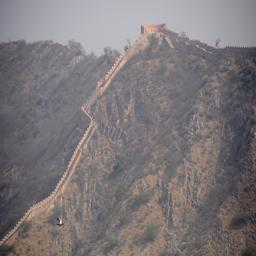

	displaying image from /home/howarwil/data/places365/places365_standard/train/car_interior/00000822.jpg


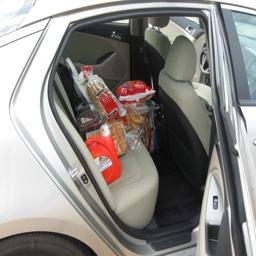

In [5]:
print(f"length of training paths list is {len(train_paths)}")

from IPython.display import Image, display

for i in range(3):
    path = train_paths[i]
    print("\tdisplaying image from", path)
    display(Image(filename=path))

In [6]:
# Make sure this is equal to NUM_CLASSES - 1
print(np.max(orig_val_classes))

364


In [7]:

# Use a subset of the classes
# selected_classes = np.random.choice(np.arange(NUM_CLASSES), size=(int(NUM_CLASSES/10)), replace=False)

selected_classes = np.arange(NUM_CLASSES)  # Use whole dataset as the database

db_indices = np.in1d(train_classes, selected_classes)
db_codes = train_codes[db_indices]
db_classes = train_classes[db_indices]

if len(selected_classes) == NUM_CLASSES:
    db_paths = np.array(train_paths)
else:
    idx_map = []
    for i in range(len(db_indices)):
        if db_indices[i]:
            idx_map.append(i)
        if i % 10000 == 0:
            print(i)
    db_paths = np.array(train_paths)[idx_map]


SAMPLE_SIZE = 5

# sample_classes = np.random.choice(np.arange(NUM_CLASSES), size=(50, 1), replace=False)
# val_indices = np.in1d(orig_val_classes, sample_classes)

# Choose samples for each class
val_indices = []
for i in selected_classes:
    indices = np.where(orig_val_classes == i)[0]
    # print(indices)
    samples = np.random.choice(indices, size=(SAMPLE_SIZE), replace=False)
    val_indices.append(samples)
val_indices = np.array(val_indices).flatten()


val_codes = orig_val_codes[val_indices]
val_classes = orig_val_classes[val_indices]
val_paths = np.array(test_paths)[val_indices]

print(f"Shape of sampled test data is {val_codes.shape}")
print(f"Shape of sampled test labels is {val_classes.shape}")

Shape of sampled test data is (1825, 2048)
Shape of sampled test labels is (1825, 1)


In [8]:
# Default number of neighbors to return
R = 100

In [9]:
# TODO: Maybe we should make a single general method that returns a specified index
import faiss
from sklearn.neighbors import NearestNeighbors

def get_index(name, db, param_val=None):
  """
  Initialize the given a type of index (name) with the given database of points and an optional param.
  """
  index = None
  database = np.ascontiguousarray(db)
  if name == "kd":
    # index = KDTree(database, leaf_size=param_val)
    index = NearestNeighbors(n_neighbors=5, algorithm='kd_tree', leaf_size=40, n_jobs=4)
    index.fit(database)
  elif name == "exact":       # exact FAISS index with L2 distance
    index = faiss.IndexFlatL2(database.shape[1])
    index.add(database)
  elif name == "lsh":
    index = faiss.IndexLSH(database.shape[1], param_val)
    index.add(database)
  elif name == "hnsw":
    index = faiss.IndexHNSWFlat(database.shape[1], param_val)
    index.add(database)
  elif name == "exact_sklearn":
    index = NearestNeighbors(n_neighbors=5, algorithm='brute', n_jobs=4)
    #index = NearestNeighbors(n_neighbors=5, algorithm='kd_tree', leaf_size=40)
    index.fit(database)
  else:
    print(name, " is not supported...")
  
  return index


In [10]:
def get_neighbors(index, query_reps, k=R):
  """
  Returns the k nearest neighbors of val_codes within the given index
  """
  query_reps = np.ascontiguousarray(query_reps)
  # TODO: Using sklearn.NN kd tree so this one is unnecessary
  if str(type(index)) == "<class 'sklearn.neighbors._kd_tree.KDTree'>":                   # KD-tree
    results = index.query(query_reps, k=k)
  elif str(type(index)) == "<class 'sklearn.neighbors._unsupervised.NearestNeighbors'>":  # Brute force search
    results = index.kneighbors(query_reps, k)
  else:
    results = index.search(query_reps, k=k)

  # print("\tSHape of results is", results[1].T.shape)
  return results[1].T  # return indices of nn in database


In [11]:
def compute_MAP(val, val_classes, db_classes, neighbors, k=R):
  """
  Computes the MAP@k (default value of k=R) on neighbors with val set by seeing if nearest neighbor
  is in the same class as the class of the val code. Let m be size of val set, and n in train.

    val:          (m x d) All the truncated vector representations of images in val set
    val_classes:  (m x 1) class index values for each vector in the val set
    db_classes:   (n x 1) class index values for each vector in the train set
    neighbors:    (k x m) indices in train set of top k neighbors for each vector in val set
  """
  
  # print("shape of val is:", val.shape)
  # print("shape of val_classes is:", val_classes.shape)
  # print("shape of db_classes is:", db_classes.shape)
  # print("shape of neighbors is:", neighbors.shape)

  """
  Places:
  shape of val is: (730, 16)
  shape of val_classes is: (730, 1)
  shape of db_classes is: (1803460, 1)
  shape of neighbors is: (100, 730)

  Imagenet:
  shape of val is: (2000, 16)
  shape of val_classes is: (2000, 1)
  shape of db_classes is: (1281167, 1)
  shape of neighbors is: (100, 2000)
  """

  APs = list()
  for i in range(val.shape[0]): # Compute precision for each vector's list of k-nn
    target = val_classes[i]
    indices = neighbors[:, i]     # neighbor list for ith val vector
    labels = db_classes[indices]
    matches = (labels == target)
    
    # print("indices", indices.shape)
    # print("labels", labels.shape)
    # print("matches", matches.shape)
    """
    All of these^ are (100, 1)
    """
    
    # true positive counts
    tps = np.cumsum(matches)
    # precision values
    precs = tps.astype(float) / np.arange(1, k + 1, 1)
    APs.append(np.sum(precs[matches.squeeze()]) / k)
    
  return np.mean(APs)

In [12]:
import pickle

def eval_index(index, val_codes, val_classes, db_classes, k=R, return_nn=False):
  """
  Returns the MAP@k and the average time to get each query for the given index.
  """
  t0 = time.time()
  neighbors = get_neighbors(index, val_codes, k=k)
  t1 = time.time()
  MAP = compute_MAP(val_codes, val_classes, db_classes, neighbors, k)

  if return_nn:
    return MAP, (t1 - t0)/len(val_codes), neighbors  # TODO: Return image nearest neighbors here?
  else:
    return MAP, (t1 - t0)/len(val_codes)


def get_size_of_index(name, index):
  if name == "exact" or name == "hnsw" or name == "lsh":  # if FAISS index
    faiss.write_index(index, 'temp.index')
  else:
    with open('temp.index', 'wb') as f:
      pickle.dump(index, f)

  return os.path.getsize('temp.index')

In [13]:

def get_index_info(name):
    if name == "kd":
        param = "nleaves"
        param_list = [40] #[10, 20, 40, 80]                   # nleaves = cutoff where we brute force
    elif name == "exact":
        param = "no_param"
        param_list = [-1]
    elif name == "lsh":
        param = "nbits"
        param_list = [256] #[32, 128, 256, 1024]               # nbits = numer of bits per stored vector
    elif name == "hnsw":
        param = "mneighbors"
        param_list = [32] #[8, 16, 32]                        # mneighbors = max number of neighbors per node
    elif name == "exact_sklearn":
        param = "no_param"
        param_list = [-1]
    else:
        print(name, "is not a valid index")
        #quit()

    return param, param_list


In [14]:

def get_results(name):
  """
  Stores metric results for given index in results folder
  """

  # Number of dimensions to benchmark
  # dims = [8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34]
  dims = [16, 32, 64, 128, 256, 2048]
  param, param_list = get_index_info(name)

  results = list()
  index = None
  for dim in dims:
    print(f'Using database with {db_codes.shape[0]} samples and {dim} features...')

    trunc_db_codes = db_codes[:, :dim]
    trunc_val_codes = val_codes[:, :dim]

    for n in param_list:
      # Garbage collect previous index
      del index
      # Get the index
      t0 = time.time()
      index = get_index(name, trunc_db_codes, n)
      t1 = time.time()
      prep_elapsed = t1 - t0

      index_size = get_size_of_index(name, index)

      # Evaluate the index
      MAP, elapsed = eval_index(index, trunc_val_codes,
                                val_classes, db_classes) # time to get 100 neighbors averaged over the val codes
      MAP_50, _ = eval_index(index, trunc_val_codes,
                                val_classes, db_classes, k=50)

      #index_name = f'{name}({param}={n})'
      #print(f'  {index_name} MAP@{R}: {MAP:.3f}, search time: {elapsed:.2f}s, prep time: {prep_elapsed:.2f}s')
      result = {
        f'{param}': n,
        'num_features': dim,
        f'MAP_{R}': MAP,
        'MAP_50': MAP_50,
        'delay': elapsed,
        'prep_time': prep_elapsed,
        'index_size': index_size,
      }
      print(result)
      results.append(result)
    print()

  torch.save(results, f'results_{DATASET}/fine_features/{name}_results_gpu0_{len(db_codes)}.pt')

In [15]:
# Set up database
name = "hnsw"
dim = 256

# Database representations
trunc_db_codes = db_codes[:,:dim]
print("Creating index...")
index = get_index(name, trunc_db_codes, param_val=32)

Creating index...


Finding nearest neighbors...
Evaluating retrieval quality
hnsw index achieves an MAP@5 of 0.0. Retrieval time per query was 0.0004923343658447266s
Query Image


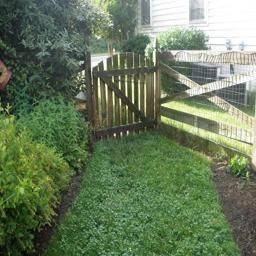

Neighbors:


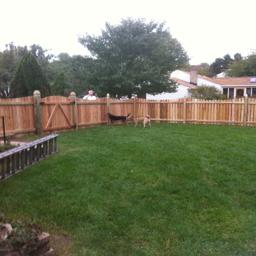

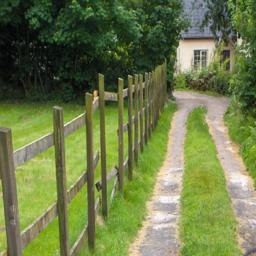

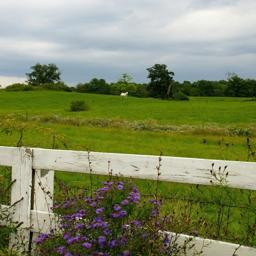

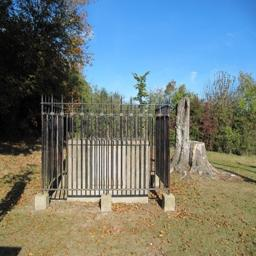

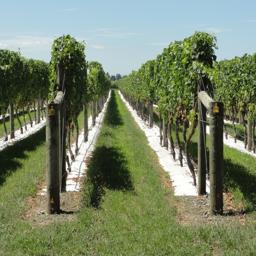



Query Image


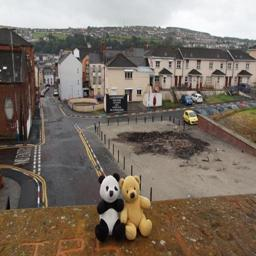

Neighbors:


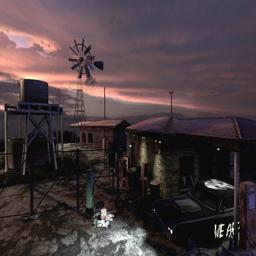

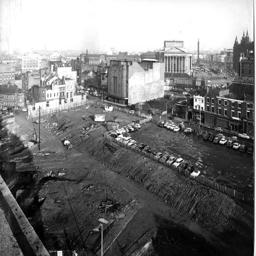

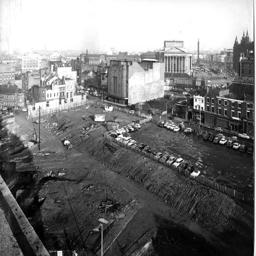

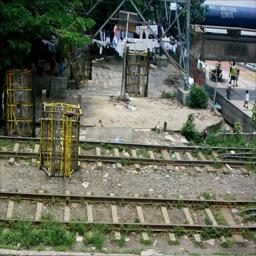

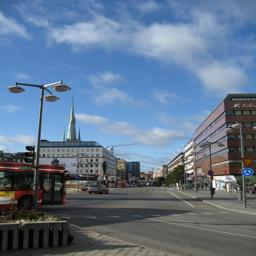



Query Image


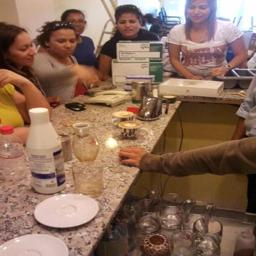

Neighbors:


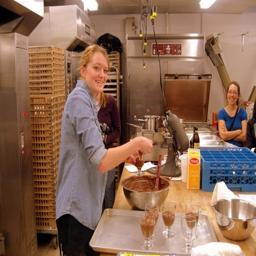

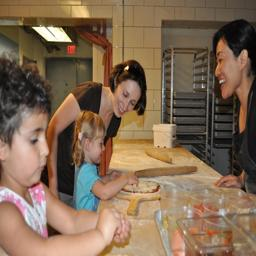

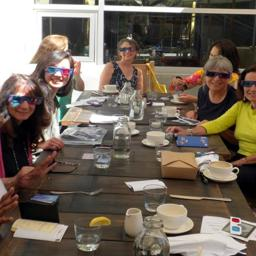

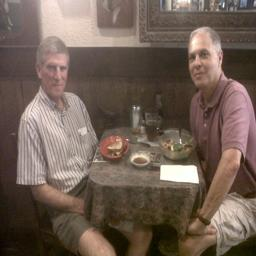

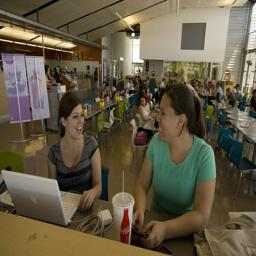

In [18]:
from IPython.display import Image, display

# Queries
trunc_val_codes = val_codes[:, :dim]
sample = np.random.choice(SAMPLE_SIZE * NUM_CLASSES, size=3, replace=False)
sample_codes = trunc_val_codes[sample, :]
sample_classes = val_classes[sample]

print("Finding nearest neighbors...")
num_neighbors = 5

print("Evaluating retrieval quality")
MAP_k, elapsed, indices = eval_index(index, sample_codes, sample_classes, db_classes, k=num_neighbors, return_nn=True)

print(f"{name} index achieves an MAP@{num_neighbors} of {MAP_k}. Retrieval time per query was {elapsed}s")

for i in range(len(sample)):
    neighbors = indices[:, i]
    query = sample[i]
    print("Query Image")
    display(Image(filename=val_paths[query]))
    print("Neighbors:")
    for nn in neighbors:
        display(Image(filename=db_paths[nn]))
    print()
    print()


In [ ]:
idxs = ["hnsw", "kd", "lsh"]


for idx in idxs:
    print("Getting results for", idx)
    get_results(idx)
    print()